# Teach an LLM to do additions

The goal of this project is to teach an LLM to do additions, playing only with two parts:
* the tokenizer
* the positional embedding

Both the model and the dataset are fixed.

You are allowed to tune the hyperparameters, but this is not the main goal. Depending on the quality of your tokenizer and positional embedding, you may change the number of bits. The initial value of 3 is very small.

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import random
import math
import re
import time

import matplotlib.pyplot as plt

In [2]:
number_bits = 4

dataset_size = 512_000
train_proportion = 0.9

log_interval = 200
# large batch_size for GPU
batch_size = 256
# learning_rate beefed up
learning_rate = 1e-3

epochs = 4

## Step 1: Construct a tokenizer

In [3]:
pad_token="[PAD]"
eos_token="[EOS]"

### Baseline: character-level tokenizer

In [4]:
class character_level_tokenizer:
    """
    character-level
    """
    def __init__(self):
        self.vocab = [str(x) for x in range(10)] + ["+", "="] + [pad_token, eos_token]
        self.token_to_id = {v : k for k, v in enumerate(self.vocab)}
        self.id_to_token = {k : v for k, v in enumerate(self.vocab)}
        self.ntokens = len(self.vocab)
        self.pattern = f"[^{re.escape(''.join(self.vocab))}]"
    
    def clean(self, text):
        """
        removes all characters not in the vocabulary
        """
        out = re.sub(self.pattern, "", text)
        return out

    def pre_tokenization(self, text):
        """
        character-level
        """
        return [c for c in text]

    def encode(self, text):
        text_list = self.pre_tokenization(self.clean(text))
        return [self.token_to_id[c] for c in text_list]

    def decode(self, token_list):
        return "".join([self.id_to_token[x] for x in token_list])

In [5]:
tokenizer = character_level_tokenizer()
ntokens = tokenizer.ntokens
ntokens

14

In [6]:
prompt = "12 + 42 ="
inputs = tokenizer.encode(prompt)
inputs, tokenizer.decode(inputs)

([1, 2, 10, 4, 2, 11], '12+42=')

# Implement your tokenizer here!

You can do anything (as long as you do not compute the addition!).
Some ideas:
* reversing numbers left to right
* arranging by groups (of, 2, 3,...)
* aligning numbers

In [7]:
class TheTentativeTokenizer:
    """OK, this is my attempt to make a tokenizer.
    The idea is simple :
    1- clean up : remove all characters that are not numeric, nor '+' nor '='
    2- assuming the prompts are "a + b =" : 
        2.1- split the prompt to get two lists of characters corresponding to a and b
        2.2- work backward, ie from the rightmost character to the leftmost character in a and b
        2.3- if one of the character is None (end of list), replace by [PAD]
        2.4- form tuples (character 1, character 2). This is a token.
    3- return all tokens
    As a result, the vocabulary is the set of tuples (char 1 x char 2) where char 1 and 2 are in [0-9, +, =, [PAD]]. Plus [EOS] special token.
    """
    
    pad_token="[PAD]"
    eos_token="[EOS]"

    def __init__(self):
        self.unit_token_list = [str(x) for x in range(10)] + ["+", "="] + [self.pad_token, self.eos_token]
        self.pattern = f"[^{re.escape(''.join(self.unit_token_list))}]"
        self.vocab = [ (c1, c2) for c1 in self.unit_token_list for c2 in self.unit_token_list ] # not all tokens will ever be used, but never mind
        self.token_to_id = {v : k for k, v in enumerate(self.vocab)}
        self.id_to_token = {k : v for k, v in enumerate(self.vocab)}
        self.ntokens = len(self.vocab)
        
    def clean(self, text):
        """
        removes all characters not in the unit character list
        """
        out = re.sub(self.pattern, "", text)
        return out
    
    def encode(self, text):
        """_summary_

        Args:
            text (_type_): prompt as an input. Assumes to be "a + b = " where a and b are strings with integers.

        Returns:
            tokens (list): list of tokens, each token being an integer
        """
        
        # remove all characters not in the vocabulary
        cleaned_text = self.clean(text)
        # split the prompt in two operands, remove everything else
        pattern = r'\+'
        operands = re.split(pattern, cleaned_text)
        # streamline the two operands
        pattern = r'[ =]'
        cleaned_operands = []
        for op in operands:
            c_op = re.sub(pattern, '', op)
            cleaned_operands.append(c_op)
        # build two lists of characters out of the cleaned operands
        list1 = [c for c in cleaned_operands[0]]
        list2 = [c for c in cleaned_operands[1]]
        # work backward, egalize lengths and form tokens
        tokens = []
        pairs = []
        list1.reverse()
        list2.reverse()
        if len(list1) < len(list2):
            list1 = list1 + [self.pad_token] * (len(list2) - len(list1))
        if len(list2) < len(list1):
            list2 = list2 + [self.pad_token] * (len(list1) - len(list2))
        # print(f"list1 = {list1}")
        # print(f"list2 = {list2}")
        for c1, c2 in zip(list1, list2):
            pair = (c1, c2)
            # print(pair)
            tokens.append(self.token_to_id[pair])
            pairs.append(pair)
        
        return tokens, pairs
        
    def decode(self, token_list):
        """Take the token list, find the associated pairs of characters, reverse and concatenate them to form the prompt

        Args:
            token_list (_type_): list of integers

        Returns:
            string : reconstructed prompt
        """
        
        list1 = []
        list2 = []
        # decompose the token list, find the associated pairs, create the two lists
        for token in token_list:
            pair = self.id_to_token[token]
            c1 = pair[0]
            c2 = pair[1]
            if c1 != self.pad_token:
                list1.append(c1)
            if c2 != self.pad_token:
                list2.append(c2)
        # reverse and form the prompt
        list1.reverse()
        list2.reverse()
        prompt = "".join(list1) + " + " + "".join(list2) + " = "
            
        return prompt

In [8]:
# tests

tok = TheTentativeTokenizer()

prompt = "1245 + 347582 ="
print(f"original prompt : '{prompt}'")

token_list, pair_list = tok.encode(prompt)
print(f"encoded prompt : {token_list}")
print(f"pairs = {pair_list}")

dec = tok.decode(token_list=token_list)
print(f"decoded token list : '{dec}'")

original prompt : '1245 + 347582 ='
encoded prompt : [72, 64, 33, 21, 172, 171]
pairs = [('5', '2'), ('4', '8'), ('2', '5'), ('1', '7'), ('[PAD]', '4'), ('[PAD]', '3')]
decoded token list : '1245 + 347582 = '


## Step 2: Create a dataset for arithmetic operations

In [9]:
def sample_datapoint(number_bits = 3):
    """
    returns a string containing two random numbers on `number_bits` many bits and their sum.
    """
    a_list = [random.randint(0, 9) for _ in range(number_bits)]
    b_list = [random.randint(0, 9) for _ in range(number_bits)]
    a_int = int("".join([str(x) for x in a_list]))
    b_int = int("".join([str(x) for x in b_list]))
    sum_int = a_int + b_int
    return (str(a_int) + "+" + str(b_int) + "=", str(sum_int))

sample_datapoint(number_bits=number_bits)

('4091+4859=', '8950')

In [10]:
data = []
for _ in range(dataset_size):
    data.append(sample_datapoint(number_bits))
data[:4]

[('7051+9214=', '16265'),
 ('1533+8021=', '9554'),
 ('9683+8290=', '17973'),
 ('9354+2431=', '11785')]

In [11]:
data_train = data[: int(train_proportion * dataset_size)]
data_test = data[int(train_proportion * dataset_size):]

len(data_train),len(data_test)

(460800, 51200)

## Step 3: Construct a model

### Baseline: the classical Positional Embedding

In [12]:
class PositionalEmbedding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens in the sequence.
        The positional encodings have the same dimension as the embeddings, so that the two can be summed.
        Here, we use sine and cosine functions of different frequencies.
    .. math:
        \text{PosEmbedder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEmbedder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # print(f"position : {position.size()}")
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        # print(f"pe = {pe}")
        # print(f"pe = {pe.size()}")
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Implement your positional embedding here!

You can do anything. Some ideas:
* RoPE
* (randomised) FIRE
* Abacus

**!!! IMPORTANT !!!** This model of Transformers is "input first", meaning that an input is a tensor with shape
(length_prompts, batch_size)

### Abacus embedding seems straightforward to implement with good results : https://arxiv.org/html/2405.17399v1#S3.F2

### Abacus 

https://arxiv.org/html/2405.17399v1#S3.F2

Quote :

"To address the limitations of transformers at representing positional information, we design a specially built positional embedding that encodes the location of each digit relative to the start of the current number. We call this Abacus Embeddings. We apply the same positional embedding to all digits of the same significance, providing an explicit signal that the model can use to align digits. 

We take inspiration from Randomized Embeddings (Ruoss et al., 2023) but instead of using random ascending indices to represent positions in a sample, we use consecutive ascending indices with a random starting position to allow for length generalization. Specifically, during training we give consecutive positional embeddings to each digit in a number, starting from a randomly chosen offset value from $U \in [1,k]$, where k is a hyperparameter. Unless otherwise stated the default value for k in this study is 100. 

For example, if the input is 123, the positional encodings are $\beta, \beta+1, \beta+2$, where $\beta \sim U \in [1,100]$ which are then passed through a learned embedding matrix. The value sampled from $U \in [1,k]$ is the same for all numbers in a batch, meaning all digits of the same significance obtain the same positional embedding. This training scheme allows the model to see a wide range of positional embeddings, even when training sequences are short. At test time, each positional embedding begins from one, i.e. $\beta = 1$"

### Some thoughts on positional encoding

In our case, the numbers of same significance (ie at the same position in the operands) are already grouped by the tokenizer.

So the position of the token itself, should be representative of the relative positions of each digit.

Should the vanilla positional embedding be enough ?

In [13]:
# class TheTentativePositionalEmbedding(nn.Module):
#         def __init__(self, d_model, dropout=0.1, max_len=5000):
#                 super(PositionalEmbedding, self).__init__()
#                 self.dropout = nn.Dropout(p=dropout)

#         # pe = torch.zeros(max_len, d_model)
#         # position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#         # print(f"position : {position.size()}")
#         # div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
#         # pe[:, 0::2] = torch.sin(position * div_term)
#         # pe[:, 1::2] = torch.cos(position * div_term)
#         # pe = pe.unsqueeze(0).transpose(0, 1)
#         # print(f"pe = {pe}")
#         # print(f"pe = {pe.size()}")
#         # self.register_buffer('pe', pe)
        
#         def forward(self, x):
#                 r"""Inputs of forward function
#                 Args:
#                 x: the sequence fed to the positional encoder model (required).
#                 Shape:
#                 x: [sequence length, batch size, embed dim]
#                 output: [sequence length, batch size, embed dim]
#                 """
#                 pass

#         # x = x + self.pe[:x.size(0), :]
#         # return self.dropout(x)

In [14]:
class TransformerModel(nn.Transformer):
    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__(d_model=ninp,
                                               nhead=nhead,
                                               dim_feedforward=nhid,
                                               num_encoder_layers=nlayers)
        self.input_emb = nn.Embedding(ntoken, ninp)
        self.pos_encoder = PositionalEmbedding(ninp, dropout)
        self.decoder = nn.Linear(ninp, ntoken)

        self.ninp = ninp
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.input_emb.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.bias)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def _generate_square_subsequent_mask(self, sz):
        return torch.log(torch.tril(torch.ones(sz,sz)))

    def forward(self, src):
        mask = self._generate_square_subsequent_mask(len(src)).to(device)
        self.src_mask = mask

        src = self.input_emb(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output_enc = self.encoder(src, mask=self.src_mask)
        output_dec = self.decoder(output_enc)
        return F.log_softmax(output_dec, dim=-1), output_enc

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Please do not change these parameters!

In [16]:
model = TransformerModel(ntoken = ntokens,
                         ninp = 128,
                         nhead = 16,
                         nhid = 64,
                         nlayers = 8)
model.to(device)

/home/benjamin.deporte/.conda/envs/LLM/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TransformerModel(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): Linear(in_features=128, out_features=14, bias=True)
  (input_emb): Embedding(14, 128)
  (pos_encoder): PositionalEmbedding(
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [17]:
def generate(model, prompts, new_tokens = 5):
    input_tensor = prompts # (length_prompts, batch_size)
    input_tensor = input_tensor.to(device)
    for _ in range(new_tokens):
        output, _ = model(input_tensor) # (length_prompts, batch_size, ntokens)
        last_output = output[-1,:,:] # (batch_size, ntokens)
        token = torch.argmax(last_output, -1).view((1,-1)) # (1, batch_size)
        input_tensor = torch.cat((input_tensor, token), 0)
    return input_tensor

In [18]:
model.eval()

prompt = "2+3="
prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1,1))
output = generate(model, prompt_tensor).view((1,-1))
output, tokenizer.decode(output.tolist()[0])

(tensor([[ 2, 10,  3, 11,  1,  1,  1,  1,  1]], device='cuda:0'), '2+3=11111')

In [19]:
def pad(token_list, type_list = "prompts"):
    max_length = max([len(x) for x in token_list])
    out = []
    for x in token_list:
        if type_list == "prompts":
            out.append([tokenizer.token_to_id[pad_token]] * (max_length - len(x)) + x)
        if type_list == "answers":
            out.append(x + [tokenizer.token_to_id[eos_token]] + [tokenizer.token_to_id[pad_token]] * (max_length - len(x)))
    return out, max_length

In [20]:
prompts = [tokenizer.encode("1+1="), tokenizer.encode("21+35=")]
answers = [tokenizer.encode("2"), tokenizer.encode("56")]
padded_prompts, _ = pad(prompts, "prompts")
padded_answers, _ = pad(answers, "answers")
padded_prompts, padded_answers
[tokenizer.decode(p) for p in padded_prompts], [tokenizer.decode(p) for p in padded_answers]

(['[PAD][PAD]1+1=', '21+35='], ['2[EOS][PAD]', '56[EOS]'])

In [21]:
def get_batch(split, i):
    data = data_train if split == 'train' else data_test
    prompts = [tokenizer.encode(data[i][0]) for i in range(i, i + batch_size)]
    padded_prompts, length_prompts = pad(prompts, "prompts")
    answers = [tokenizer.encode(data[i][1]) for i in range(i, i + batch_size)]
    padded_answers, length_answers = pad(answers, "answers")
    X = torch.stack([torch.tensor(x) for x in padded_prompts], 1)
    Y = torch.stack([torch.tensor(x) for x in padded_answers], 1)
    return X, Y, length_prompts, length_answers

In [22]:
X, Y, length_prompts, length_answers = get_batch("train", 243)
X.shape, Y.shape, length_prompts, length_answers

(torch.Size([10, 256]), torch.Size([6, 256]), 10, 5)

## Step 4: Evaluate

In [23]:
def evaluate():
    # Turn on evaluation mode disables dropout.
    model.eval()
    correct = 0.
    with torch.no_grad():
        for batch, i in enumerate(range(0, len(data_test) - 1, batch_size)):
            prompts, target_answers, length_prompts, length_answers = get_batch("test", i)
            prompts = prompts.to(device) # (length_prompts, batch_size)
            target_answers = target_answers.to(device) # (length_answers + 1, batch_size)
            output = generate(model, prompts, length_answers + 1) # (length_prompts + length_answers + 1, batch_size)
            answers_tokens = output[length_prompts:, :] # (length_answers + 1, batch_size), contains tokens
            equality_test = answers_tokens == target_answers # (length_answers + 1, batch_size), contains boolean values
            correct += torch.all(equality_test, axis=0).float().sum()
        accuracy = correct / len(data_test)
    return accuracy.item()

In [24]:
evaluate()

0.0

## Step 4: Train the model

In [25]:
def train_epoch():
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    total_loss = 0.
    start_time = time.time()
    for batch, i in enumerate(range(0, len(data_train) - 1, batch_size)):
        prompts, target_answers, length_prompts, length_answers = get_batch("train", i)
        prompts = prompts.to(device) # (length_prompts, batch_size)
        target_answers = target_answers.to(device) # (length_answers, batch_size)
        input_tensor = torch.cat((prompts, target_answers), 0) # (length_prompts + length_answers, batch_size)
        model.zero_grad()
        output, _ = model(input_tensor) # (length_prompts + length_answers, batch_size, ntokens)
        output_answers = output[length_prompts-1:-1,:,:].reshape(-1, ntokens) # (length_answers * batch_size, ntokens)
        target_answers = target_answers.view(-1)
        loss = F.cross_entropy(output_answers, target_answers)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| {:5d}/{:5d} batches | ms/batch {:5.2f} | loss {:5.2f} | perplexity {:8.2f}'.format(batch, len(data_train) // batch_size,
                                                                                                        elapsed * 1000 / log_interval, cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def train(epochs=3):
    accuracy_v_epoch = []
    best_test_accuracy = None
    test_accuracy = evaluate()
    print('-' * 89)
    print('| initialisation | test accuracy {:5.2f}'.format(test_accuracy))
    print('-' * 89)
    for epoch in range(1, epochs+1):
        epoch_start_time = time.time()
        train_epoch()
        test_accuracy = evaluate()
        accuracy_v_epoch.append(test_accuracy)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | test accuracy {:5.2f}'.format(epoch, (time.time() - epoch_start_time), test_accuracy))
        print('-' * 89)
        # Save the model if the test accuracy is the best we've seen so far.
        if not best_test_accuracy or test_accuracy < best_test_accuracy:
            with open("arithmetic.pt", 'wb') as f:
                torch.save(model, f)
            best_test_accuracy = test_accuracy
            
    return accuracy_v_epoch

In [26]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(f"Training on {device}")

Training on cuda


In [36]:
nbits = 3
results = {}

# create dataset
data = []
for _ in range(dataset_size):
    data.append(sample_datapoint(number_bits=nbits))
data_train = data[: int(train_proportion * dataset_size)]
data_test = data[int(train_proportion * dataset_size):]

# reporting out
print(f"Dataset à {nbits} bits : {data_train[0]}")

# instantiate model
model = TransformerModel(ntoken = ntokens,
                         ninp = 128,
                         nhead = 16,
                         nhid = 64,
                         nlayers = 8)
model.to(device)

# go
learning_rate = 1e-3
epochs = 4

acc_v_epoch = train(epochs=epochs)

Dataset à 3 bits : ('313+45=', '358')
-----------------------------------------------------------------------------------------
| initialisation | test accuracy  0.00
-----------------------------------------------------------------------------------------
|   200/ 1800 batches | ms/batch 19.96 | loss  1.70 | perplexity     5.48
|   400/ 1800 batches | ms/batch 19.86 | loss  1.27 | perplexity     3.57
|   600/ 1800 batches | ms/batch 19.86 | loss  1.16 | perplexity     3.18
|   800/ 1800 batches | ms/batch 20.39 | loss  1.10 | perplexity     3.01
|  1000/ 1800 batches | ms/batch 19.93 | loss  1.07 | perplexity     2.92
|  1200/ 1800 batches | ms/batch 19.92 | loss  1.06 | perplexity     2.88
|  1400/ 1800 batches | ms/batch 19.90 | loss  1.04 | perplexity     2.83
|  1600/ 1800 batches | ms/batch 19.87 | loss  1.03 | perplexity     2.79
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 40.48s | test accuracy  0.01
-----

In [37]:
model.eval()

for i in range(10):
    prompt, answers = data_test[i]
    prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1,1))
    output = generate(model, prompt_tensor, len(answers)).view((1,-1))
    print(tokenizer.decode(output.tolist()[0]) + "\t actual result: " + answers)

483+458=941	 actual result: 941
95+542=147	 actual result: 637
372+264=636	 actual result: 636
472+971=1443	 actual result: 1443
943+387=1330	 actual result: 1330
238+707=945	 actual result: 945
772+33=111	 actual result: 805
104+616=720	 actual result: 720
596+833=1429	 actual result: 1429
738+481=1219	 actual result: 1219


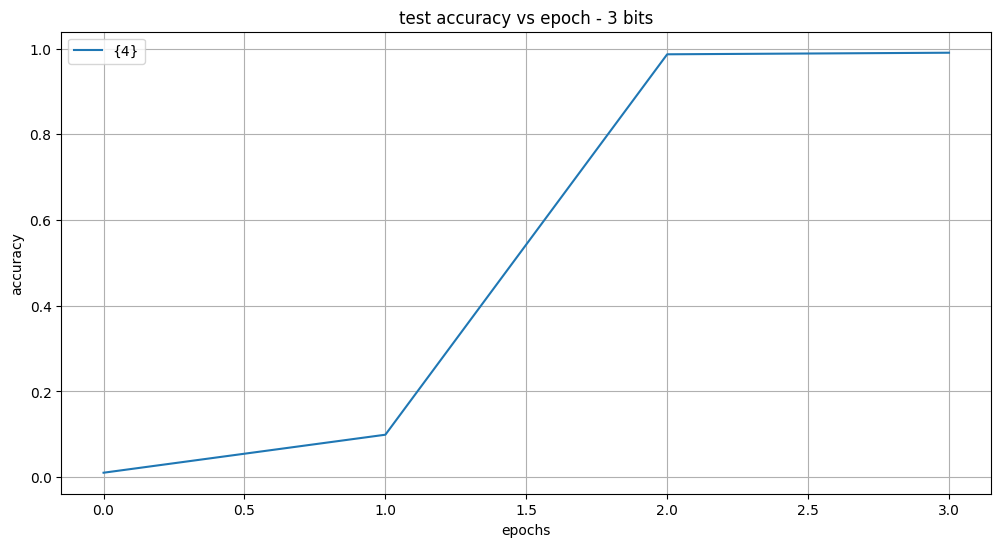

In [38]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(acc_v_epoch, label={number_bits})
ax.set_title(f"test accuracy vs epoch - {nbits} bits")
ax.set_xlabel(f"epochs")
ax.set_ylabel(f"accuracy")
ax.legend()
ax.grid(True)
plt.show()

# Step 5 : testing with different number of bits

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

list_nbits = [3,4,5,9]
list_epochs = [5,10,30,30]
results = {}

for epochs, nbits in zip(list_epochs,list_nbits):
    # create dataset
    data = []
    for _ in range(dataset_size):
        data.append(sample_datapoint(number_bits=nbits))
    data_train = data[: int(train_proportion * dataset_size)]
    data_test = data[int(train_proportion * dataset_size):]
    # reporting out
    print(f"Dataset à {nbits} bits : {data_train[0]}")
    # instantiate model
    model = TransformerModel(ntoken = ntokens,
                         ninp = 128,
                         nhead = 16,
                         nhid = 64,
                         nlayers = 8)
    model.to(device)
    # get training results
    print(f"Training {epochs} epochs on {nbits} bits")
    results[nbits] = train(epochs=epochs)

cuda


Dataset à 3 bits : ('421+921=', '1342')
Training 5 epochs on 3 bits
-----------------------------------------------------------------------------------------
| initialisation | test accuracy  0.00
-----------------------------------------------------------------------------------------
|   200/ 1800 batches | ms/batch 20.02 | loss  1.67 | perplexity     5.31
|   400/ 1800 batches | ms/batch 20.39 | loss  1.28 | perplexity     3.59
|   600/ 1800 batches | ms/batch 19.91 | loss  1.16 | perplexity     3.20
|   800/ 1800 batches | ms/batch 19.91 | loss  1.10 | perplexity     3.01
|  1000/ 1800 batches | ms/batch 19.95 | loss  1.07 | perplexity     2.93
|  1200/ 1800 batches | ms/batch 20.00 | loss  1.05 | perplexity     2.87
|  1400/ 1800 batches | ms/batch 20.02 | loss  1.04 | perplexity     2.83
|  1600/ 1800 batches | ms/batch 20.02 | loss  1.03 | perplexity     2.79
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 40.7

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

for r, accs in results.items():
    ax.plot(accs, label=f"{r}-bits")
    
ax.set_title(f"test accuracy vs epoch")
ax.set_xlabel(f"epochs")
ax.set_ylabel(f"accuracy")
ax.legend()
ax.grid(True)
plt.show()

## Probing

This is just for fun...

In [ ]:
import numpy as np

train_size = 1000
test_size = 100

model.eval()

def data_probing(size):
    X = []
    y = np.zeros(size)
    for i in range(size):
        input = torch.tensor(tokenizer.encode(data[i][0])).view((-1, 1)).to(device)
        _, output = model(input)
        output = output[-1,:,:].flatten()
        # determine whether there was a carry in the result:
        carry = len(data[i][1]) > len(data[i][0]) / 2
        X.append(output.cpu().detach().numpy())
        y[i] = carry
    return np.array(X), y

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

X_train, y_train = data_probing(train_size)
X_test, y_test = data_probing(test_size)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

reg = LogisticRegression()
reg.fit(X_train,y_train)
reg.score(X_test, y_test)